In [1]:
import os, glob, re, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image


import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ReduceLROnPlateau
from keras import layers, optimizers, losses, metrics


import sklearn
from keras import utils
from sklearn.preprocessing import LabelEncoder

In [2]:
# dir_path points towards where to find the image dataset
dir_path_train = "data/train/"
dir_path_test = "data/test/"
IMAGE_SHAPE = (224, 224)

# This is a good sample as it gives a good mix of val data
random_sample = 1

In [3]:
# Read the folders folders
directories_train, directories_test = os.listdir(dir_path_train), os.listdir(dir_path_test)

files_train, files_test = [], []
labels_train, labels_test = [], []

for folder in directories_train:
    
    fileList = glob.glob(f'{dir_path_train}/{folder}/*')
    labels_train.extend([folder for _ in fileList])
    files_train.extend(fileList)

for folder in directories_test:
    fileList = glob.glob(f'{dir_path_test}/{folder}/*')
    labels_test.extend([folder for _ in fileList])
    files_test.extend(fileList)

len(files_train), len(labels_train), len(files_test), len(labels_test)

(3000, 3000, 582, 582)

In [4]:
# Count the number of labels to get an idea of how balanced the dataset is
unique_train, counts_train = np.unique(labels_train, return_counts=True)
unique_test, counts_test = np.unique(labels_test, return_counts=True)
print(dict(zip(unique_train, counts_train)))
print(dict(zip(unique_test, counts_test)))

{'airplanes': 1000, 'cars': 1000, 'ships': 1000}
{'airplanes': 189, 'cars': 193, 'ships': 200}


In [5]:
# One hot encoding for train

# Encode class values as integers
encoder_train, encoder_test = LabelEncoder(), LabelEncoder()
encoder_train.fit(labels_train)
encoder_test.fit(labels_test)
encoded_Y_train = encoder_train.transform(labels_train)
encoded_Y_test  = encoder_test.transform(labels_test)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = utils.to_categorical(encoded_Y_train,dtype ="uint8", num_classes = 3)
dummy_y_test = utils.to_categorical(encoded_Y_test,dtype ="uint8", num_classes = 3)

labels_train = np.array(dummy_y_train)
labels_test = np.array(dummy_y_test)

print(f"Classes are {encoder_train.classes_}")

Classes are ['airplanes' 'cars' 'ships']


In [6]:
images_train, images_test = [], []

for path in files_train:
    img_arr = cv2.imread(path)
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    resized_arr = cv2.resize(img_arr, (256, 256)) # Reshaping images to preferred size
    images_train.append(resized_arr)

for path in files_test:
    img_arr = cv2.imread(path)
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    resized_arr = cv2.resize(img_arr, (256, 256)) # Reshaping images to preferred size
    images_test.append(resized_arr)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(images_train, labels_train, test_size=.1, random_state = random_sample)
x_test, y_test = images_test, labels_test

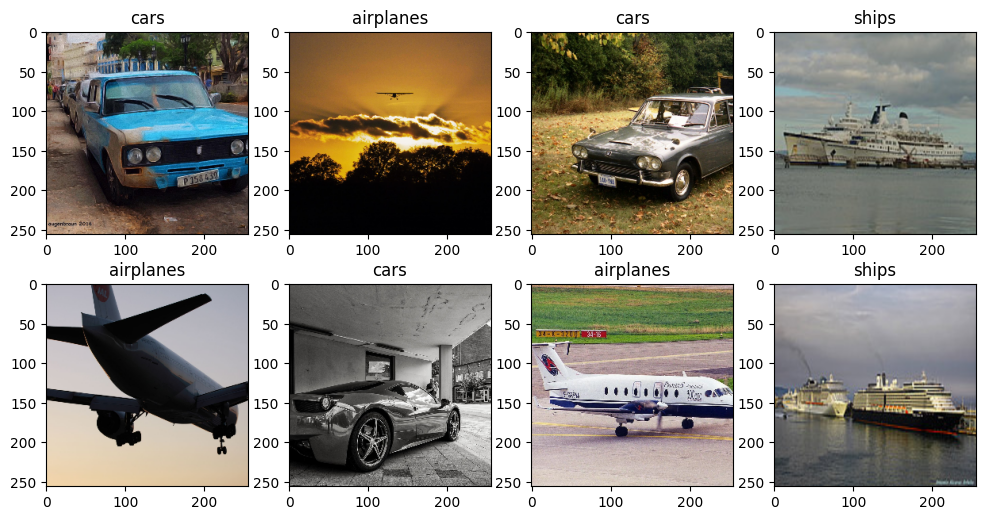

In [13]:
fig, axs = plt.subplots(2,4, figsize = (12,6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(x_train[i])
    ax.set_title(encoder_train.classes_[np.argmax(y_train[i])])

In [14]:
x_train  = np.array(x_train)
x_val    = np.array(x_val)
x_test   = np.array(x_test)
x_test   = np.array(images_test)

y_train   = np.array(y_train)
y_val     = np.array(y_val)
y_test    = np.array(y_test)
y_test    = np.array(labels_test)

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [19]:
from tensorflow.keras.applications import EfficientNetV2S
base_model = EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=((256, 256, 3)),
    classes=2,)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st FC layer
x = layers.Flatten()(x) 
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(3, 'softmax')(x)

incept_model = keras.models.Model(inputs = base_model.input, outputs = x)

# compile the model
incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.categorical_crossentropy, metrics= [metrics.CategoricalAccuracy()])

In [20]:
best_model = keras.callbacks.ModelCheckpoint(filepath='./models/best_model_epoch_{epoch:02d}.h5', save_best_only=False)

In [21]:
history = incept_model.fit(datagen.flow(x_train,y_train, batch_size = 32), batch_size = 32, epochs = 5 , validation_data = (x_val, y_val), callbacks=[best_model])

Epoch 1/5
85/85 [==============================] - ETA: 0s - loss: 0.1215 - categorical_accuracy: 0.9778

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 149s 2s/step - loss: 0.1215 - categorical_accuracy: 0.9778 - val_loss: 0.2145 - val_categorical_accuracy: 1.0000
Epoch 2/5
85/85 [==============================] - 140s 2s/step - loss: 0.0236 - categorical_accuracy: 0.9974 - val_loss: 0.0177 - val_categorical_accuracy: 1.0000
Epoch 3/5
85/85 [==============================] - 146s 2s/step - loss: 0.0103 - categorical_accuracy: 0.9978 - val_loss: 0.0142 - val_categorical_accuracy: 1.0000
Epoch 4/5
85/85 [==============================] - 144s 2s/step - loss: 0.0062 - categorical_accuracy: 0.9989 - val_loss: 9.6494e-04 - val_categorical_accuracy: 1.0000
Epoch 5/5
85/85 [==============================] - 149s 2s/step - loss: 0.0112 - categorical_accuracy: 0.9963 - val_loss: 1.2607e-04 - val_categorical_accuracy: 1.0000


In [22]:
best_model = keras.models.load_model("models/best_model_epoch_05.h5")

In [23]:
def argmax_array(array):
    return([np.argmax(item) for item in array])

In [24]:
predictions = best_model.predict(x_test)

print(classification_report(argmax_array(y_test), argmax_array(predictions), target_names = encoder_train.classes_, digits = 3))

cm = confusion_matrix(argmax_array(y_test), argmax_array(predictions))

19/19 [==============================] - 26s 1s/step
              precision    recall  f1-score   support

   airplanes      1.000     0.984     0.992       189
        cars      0.990     1.000     0.995       193
       ships      0.995     1.000     0.998       200

    accuracy                          0.995       582
   macro avg      0.995     0.995     0.995       582
weighted avg      0.995     0.995     0.995       582



In [25]:
incorrect_images = []
incorrect_labels = []

for image, label, pred in zip(x_test, y_test, argmax_array(predictions)):
    if np.argmax(label) != pred:
        incorrect_images.append(image)
        incorrect_labels.append(label)

print(len(incorrect_labels))


3


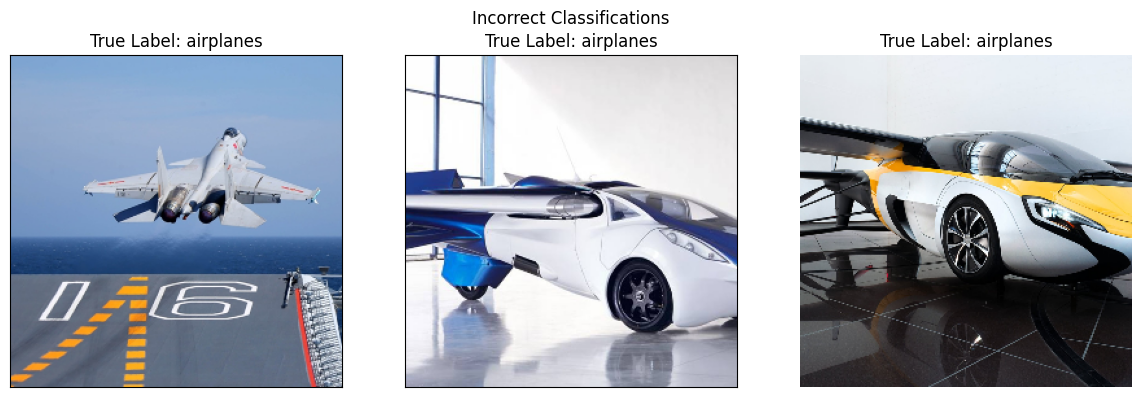

In [27]:
fig, axs = plt.subplots(1,3, figsize = (12,4))



for i, ax in enumerate(axs.flatten()):
    if i < len(incorrect_labels):
        ax.imshow(incorrect_images[i])
        ax.set_title(f"True Label: {encoder_train.classes_[np.argmax(y_test[i])]}")
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.suptitle("Incorrect Classifications")

plt.axis('off')
plt.tight_layout()